In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import jsonpickle


Expectation of OU Process: 0.3395955256449391
Variance of OU Process: 0.04415716841969287


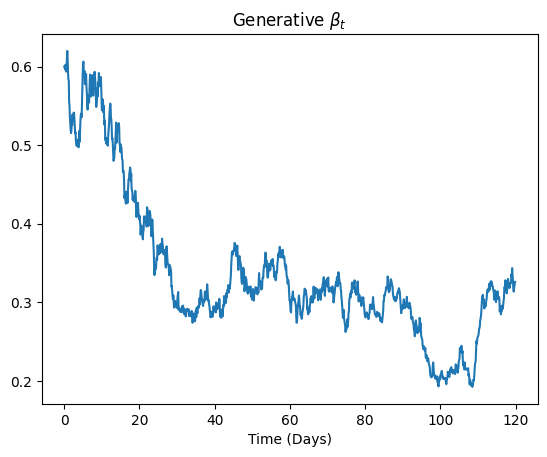

In [2]:
'''Simulated Data, setting up the SIR model'''

rng = np.random.default_rng(0)
model_params = {'gamma':1/14,'eta':1/7,'q':0.1,'mu':0.004,'R':50}

T = 120
dt = 0.1

SEIR_OU_model_params = jsonpickle.encode(model_params)

with open("../param_sets/SEIR_OU_model_params.json", "w+") as f:
    f.write(SEIR_OU_model_params)

t_vec = np.arange(0,T,dt)

'''IC'''
N = 100_000
I = 5
E = 5

'''OU params'''
OU_params = {'lambda':1/20,'mean_ou':-1.1,'sig':0.2}

SEIR_OU_process_params = jsonpickle.encode(OU_params)
with open("../param_sets/SEIR_OU_process_params.json", "w+") as f:
    f.write(SEIR_OU_process_params)

gamma,eta,q,mu,R = model_params.values()
lam,mean_ou,sig = OU_params.values()

print(f"Expectation of OU Process: {np.exp(mean_ou + (sig**2)/2)}")
print(f"Variance of OU Process: {np.exp(sig**2 - 1) * np.exp(2 * mean_ou + sig**2)}")



A = np.exp(-lam * dt)
M = mean_ou * (np.exp(-lam * dt) - 1)
C = sig * np.sqrt(1 - np.exp(-2 * lam * dt))

betas = np.zeros_like(t_vec)
betas[0] = 0.6
for time_index in range(1,len(t_vec)):
    betas[time_index] = np.exp(A * np.log(betas[time_index - 1]) - M + C * rng.normal(0,1))

state = np.zeros((5,len(t_vec)))
state[:,0] = np.array([N - I - E,E, I, 0,0])

plt.title('Generative $\\beta_t$')
plt.xlabel('Time (Days)')
plt.plot(t_vec,betas)

for time_index in range(1,len(t_vec)):

    new_E = (betas[time_index - 1] * (state[1,time_index -1] + q * state[2,time_index - 1]) * state[0,time_index - 1]/np.sum(state[:,time_index-1])) * dt
    new_I = (eta * state[1,time_index - 1]) * dt
    new_ER = (gamma * state[1,time_index -1]) * dt
    new_IR = (gamma * state[2,time_index - 1]) * dt
    new_D = (mu * state[2,time_index - 1]) * dt


    state[0,time_index] = state[0,time_index - 1] - new_E #S 
    state[1,time_index] = state[1,time_index - 1] + new_E - new_I - new_ER
    state[2,time_index] = state[2,time_index-1] + new_I - new_IR - new_D
    state[3,time_index] = state[3,time_index - 1] + new_ER + new_IR #R
    state[4,time_index] = new_I



    

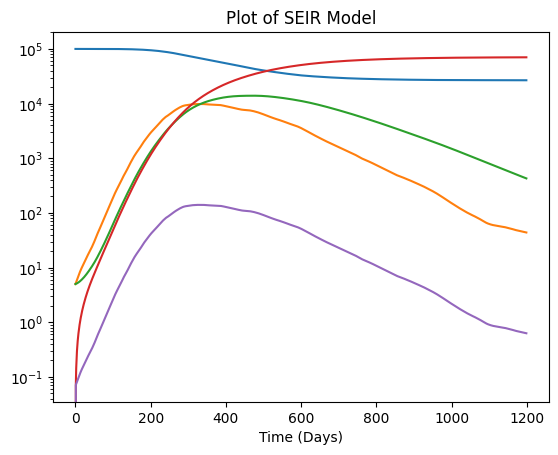

In [3]:
plt.yscale('log')
plt.title('Plot of SEIR Model')
plt.xlabel('Time (Days)')
plt.plot(state.T)

pd.DataFrame(state).to_csv('../data_sets/ou_state_nbinom.csv',index = False)
pd.DataFrame(betas).to_csv('../data_sets/ou_betas_nbinom.csv',index = False)

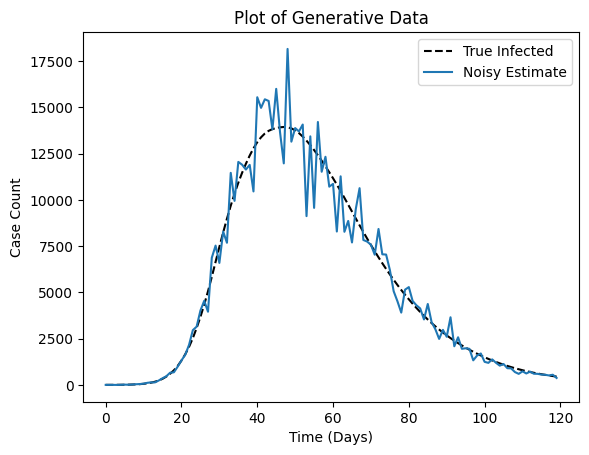

In [4]:

data = np.expand_dims(rng.negative_binomial(n = R,p = R/(R + state[2,::int(1/dt)] + 0.005)),0)

plt.title('Plot of Generative Data')
plt.xlabel('Time (Days)')
plt.ylabel('Case Count')
plt.plot(t_vec[::int(1/dt)],state[2,::int(1/dt)],'--',color = 'black',label = 'True Infected')
plt.plot(t_vec[::int(1/dt)],data.T,label = 'Noisy Estimate')
plt.legend()

In [5]:
pd.DataFrame(data).to_csv('../data_sets/ou_data_nbinom.csv',index = False)